# Assignment Part 1: Perceptron Template

This file contains the template code for the Perceptron.

### Perceptron Class

# 1.1. Implementation of the Perceptron

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.special import expit
import time
class Perceptron(object):
    #==========================================#
    # The init method is called when an object #
    # is created. It can be used to initialize #
    # the attributes of the class.             #
    #==========================================#
    def __init__(self, no_inputs, max_iterations=50,learning_rate=0.01, activation="step",rebalanced=True):
        self.no_inputs = no_inputs
        self.max_iter = max_iterations
        self.learning_rate = learning_rate
        self.activation = activation
        self.rebalanced = rebalanced
    
    '''
    # In this case, the perceptron will only perform binary classification, 
    but the dataset contain 10 different classes, so the relabeling will led to a heavily imbalance dataset on the y==0. 
    In order to avoid overfitting on the irrelevant data, 
    I included an undersampling function to make the learning more balanced.
    '''
    def undersampling(self, X, y):
        #Find indices of each class
        # in the process of relabeling for binary classificaiton, y==1 will always represent the minority class 
        indices_minority= np.where(y== 1)[0]
        indices_majority= np.where(y== 0)[0]
    
        #count images in the minority class
        num_minority=len(indices_minority)
           
        #Randomly select the same number of images in the majority 
        np.random.seed(42)
        np.random.shuffle(indices_majority)
        indices_majority_undersampled=indices_majority[:num_minority]
        
        # Combine all indices of minority + selected majority
        indices_undersampled=np.concatenate((indices_minority,indices_majority_undersampled))
        return X[indices_undersampled], y[indices_undersampled]
        
    #=======================================#
    # Prints the details of the perceptron. #
    #=======================================#
    def print_details(self):
        print("No. inputs:\t" + str(self.no_inputs+1)) # including the weight + bias so we need +1
        print("Max iterations:\t" + str(self.max_iter))
        print("Learning rate:\t" + str(self.learning_rate))
        print("Activation function:\t" + str(self.activation))

    def activate_sigmoid(self, a):
        # TO-DO: implement sigmoid
        # return 1 / (1 + np.exp(-a)) 
        return expit(a)   # In case the exponential is too big, switch to using expit for a more stable sigmoid calculation 
        
    def activate_step(self, a):
        # TO-DO: implement step
        return np.where(a>=0,1,0)
    
    #=========================================#
    # Performs feed-forward prediction on one #
    # set of inputs.                          #
    #=========================================#

    def do_predict(self, a):
        # TO-DO:
        output = np.matmul(a, self.weights) + self.bias    
        if self.activation == 'sig':
            return self.activate_sigmoid(output)
        elif self.activation == 'step':
            return self.activate_step(output)

    #======================================#
    # Trains the perceptron using labelled #
    # training data.                       #
    #======================================#
    def train_online(self, training_data, labels):
        assert len(training_data) == len(labels)
        if self.rebalanced:
        # Rebalancing the binary classes
            training_data, labels = self.undersampling(training_data, labels)
        
        # Shuffle the data and labels
        np.random.seed(42)
        indices = np.random.permutation(len(training_data))
        shuffled_data = training_data[indices]
        shuffled_labels = labels[indices]
        
        # Initiate the errors to track during the training process
        self.errors_ = []
        # Initiate the weights and bias
        self.weights = np.zeros(training_data.shape[1])
        self.bias = 0
        start_time=time.time()
        for _ in range(self.max_iter):
            errors = 0
            for xi, expected_value in zip(shuffled_data, shuffled_labels):
                pred = self.do_predict(xi)             
                update = self.learning_rate * (expected_value - pred)
                # Calculate error
                errors += int(update != 0)
                # Update weights and bias
                self.weights += update * xi
                self.bias += update        
            self.errors_.append(errors)
        end_time=time.time()
        training_time=end_time - start_time 
        print(f"Total training time: {training_time} seconds")

    def train_batch(self, training_data, labels):
        assert len(training_data) == len(labels)
        if self.rebalanced:
        # Rebalancing the binary classes
            training_data, labels = self.undersampling(training_data, labels)
        # Initiate the errors to track during the training process
        self.errors_ = []
        # Initiate the weights and bias
        self.weights = np.zeros(training_data.shape[1])
        self.bias = 0
        start_time=time.time()
        # Looping forward 
        for epoch in range(self.max_iter):
            pred = self.do_predict(training_data)
            
            # Calculate error
            error = np.mean(np.abs(labels - pred))
            self.errors_.append(error)
            
            # Update weights and bias
            update = self.learning_rate * (labels - pred) 
            update = update.reshape(-1, 1)  
            self.weights += np.matmul(update.T, training_data).flatten()
            self.bias += self.learning_rate * np.sum(labels - pred)
        end_time=time.time()
        training_time=end_time - start_time 
        print(f"Total training time: {training_time} seconds")
    #=========================================#
    # Tests the prediction on each element of #
    # the testing data. Prints the precision, #
    # recall, and accuracy of the perceptron. #
    #=========================================#
    def test(self, testing_data, labels):
        assert len(testing_data) == len(labels)
        #TO-DO:
        pred = self.do_predict(testing_data)
        # sigmoid returns a probability in range from 0 to 1 so we need to convert the result back to binary 
        if self.activation == 'sig':
            pred = np.where(pred >= 0.5, 1, 0) # we use 0.5 as the threshold
        # Calculate TP/TN/FP/FN
        TP= sum((labels==1)&(pred==1))
        TN= sum((labels==0)&(pred==0))
        FP= sum((labels==0)&(pred==1))
        FN= sum((labels==1)&(pred==0))
        # accuracy
        accuracy= (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) != 0 else 0
        # precision
        precision= TP/(TP+FP) if (TP+FP) != 0 else 0
        # recall
        recall= TP/(TP+FN) if (TP+FN)!= 0 else 0
        # F1 score
        f1= (2*precision*recall)/(precision+recall) if (precision+recall !=0) else 0
        print("Accuracy:\t"+str(accuracy))
        print("Precision:\t"+str(precision))
        print("Recall:\t"+str(recall))
        print("F1 score:\t"+str(f1))
        return accuracy, precision, recall,f1

C:\Users\Newowner\AppData\Local\Temp\ipykernel_19120\3944527638.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Main

The following cell should:
1. Load the fashion mnist training and testing data.
2. Create a Perceptron node.
3. Train and test the node.
4. Print out clothes/shoes and weights.

## 1.1.2. Importing data

In [2]:
pip install pandas gdown

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import gdown

#The url of the 3 files
urls=['https://drive.google.com/uc?id=1MY72RSdoJ5IBGzBGysF8XpeVwaWqwJhz',
    'https://drive.google.com/uc?id=1_PgTS-sdULzMN_uNbSK4azzmJyjCxKgG',
    'https://drive.google.com/uc?id=1CiRmJz3jTrwOEMzw5-0G2Jyov4c9KsGP']

# setting file names
outputs= ['overhead_mnist_classes.csv','overhead_mnist_test.csv', 'overhead_mnist_train.csv']

# download the files
for url,output in zip(urls, outputs):
    gdown.download(url,output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1MY72RSdoJ5IBGzBGysF8XpeVwaWqwJhz
To: C:\Users\Newowner\Strathclyde\CS802 - Deel Learning and Neural Nets\Lab\overhead_mnist_classes.csv
100%|██████████| 135/135 [00:00<?, ?B/s] 
Downloading...
From: https://drive.google.com/uc?id=1_PgTS-sdULzMN_uNbSK4azzmJyjCxKgG
To: C:\Users\Newowner\Strathclyde\CS802 - Deel Learning and Neural Nets\Lab\overhead_mnist_test.csv
100%|██████████| 24.6M/24.6M [00:01<00:00, 21.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1CiRmJz3jTrwOEMzw5-0G2Jyov4c9KsGP
From (redirected): https://drive.google.com/uc?id=1CiRmJz3jTrwOEMzw5-0G2Jyov4c9KsGP&confirm=t&uuid=a04dc845-2aa2-42e9-8b63-b7aa759293b6
To: C:\Users\Newowner\Strathclyde\CS802 - Deel Learning and Neural Nets\Lab\overhead_mnist_train.csv
100%|██████████| 196M/196M [00:07<00:00, 25.4MB/s] 


In [4]:
# Adding columns names
pixel_col = ['pixel'+str(i) for i in range(1,785)]
class_col = ['class']

# Reading each files into df
classes = pd.read_csv('overhead_mnist_classes.csv')
train_df = pd.read_csv('overhead_mnist_train.csv', header=None, names=class_col+pixel_col)
test_df = pd.read_csv('overhead_mnist_test.csv', header=None, names=class_col+pixel_col)

# Splitting the data
y_train = np.asarray(train_df['class'])
y_test = np.asarray(test_df['class'])
# Normalizing the input as they are pixel values between 0-255
X_train = np.asarray(train_df.drop(['class'], axis=1))/255
X_test = np.asarray(test_df.drop(['class'], axis=1))/255

# Create binary labels just for ships
y_ship_train = np.where(y_train==7,1,0)
y_ship_test = np.where(y_test==7,1,0)

## 1.1. Implement the perceptron

In [5]:
# Train and test using the step activation function and online learning
perceptron_step_online = Perceptron(no_inputs=X_train.shape[1], 
                                    activation='step')
perceptron_step_online.print_details()
perceptron_step_online.train_online(X_train, y_ship_train)
perceptron_step_online.test(X_test, y_ship_test)

No. inputs:	785
Max iterations:	50
Learning rate:	0.01
Activation function:	step
Total training time: 7.789440631866455 seconds
Accuracy:	0.7855633802816901
Precision:	0.304943913585376
Recall:	0.8265765765765766
F1 score:	0.44552352048558425


(0.7855633802816901,
 0.304943913585376,
 0.8265765765765766,
 0.44552352048558425)

We visualize the error after each iteration and can visually see the reduction in error happen quite rapidly in the first 10 iterations. Afterward, while the error has some fluctuate, it slowly continues to reduce and converge to a minimum.

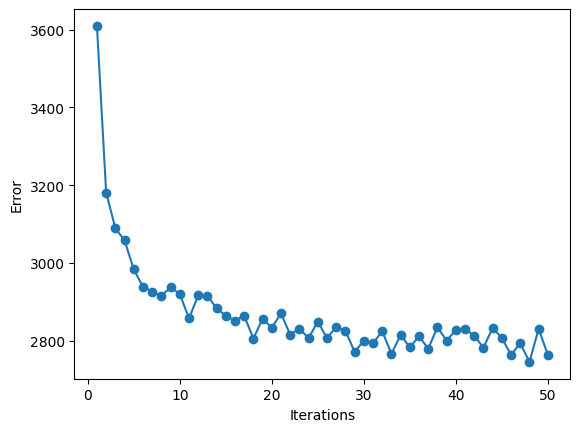

In [6]:
plt.plot(range(1, len(perceptron_step_online.errors_) + 1), 
         perceptron_step_online.errors_, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

## 1.2. Update the perceptron implementation to use full batch learning

In [7]:
# Train and test for activation == 'sig' + train_online
perceptron_step_batch = Perceptron(no_inputs=X_train.shape[1], 
                                    activation='step')
perceptron_step_batch.print_details()
perceptron_step_batch.train_batch(X_train, y_ship_train)
res = perceptron_step_batch.test(X_test, y_ship_test)

No. inputs:	785
Max iterations:	50
Learning rate:	0.01
Activation function:	step
Total training time: 0.4340226650238037 seconds
Accuracy:	0.8856807511737089
Precision:	0.285
Recall:	0.06418918918918919
F1 score:	0.10477941176470587


## 1.3. Use the sigmoid activation function 

In [8]:
# Train and test for activation == 'sig' + train_online
perceptron_sigmoid_online = Perceptron(no_inputs=X_train.shape[1], 
                                    activation='sig')
perceptron_sigmoid_online.print_details()
perceptron_sigmoid_online.train_online(X_train, y_ship_train)
res = perceptron_sigmoid_online.test(X_test, y_ship_test)

No. inputs:	785
Max iterations:	50
Learning rate:	0.01
Activation function:	sig
Total training time: 4.177870750427246 seconds
Accuracy:	0.8703051643192489
Precision:	0.42847725774555045
Recall:	0.7319819819819819
F1 score:	0.5405405405405406


## 1.4. Use multiple perceptrons to classify every dataset type

### Perform analysis over the different combinations for the best results: 
- activation: step, learning: online
- activation: step, learning: batch
- activation: sigmoid, learning: online
- activation: sigmoid, learning: batch.

### 1.4.1. Perform analysis on the ship binary data

First we perform training and testing for the task of binary classification of the ship images, looping through all 4 different combination
(1) activation: step, learning: online, 
(2) activation: step, learning: batch, 
(3) activation: sigmoid, learning: online, 
(4) activation: sigmoid, learning: batch.

In [9]:
# First we prepare a function that will perform  binary classification using all 4 combinations of the perceptron
def binary_perceptron(max_iterations=20):
    # Create a list of activation functions and training methods
    activation_functions= ['step','sig']
    training_methods= ['online','batch']
    
    # Create an empty list to store results
    results=[]
    weights=[]
    # Iterate over combinations of activation functions and training methods
    for activation in activation_functions:
        for method in training_methods:
            # Prepare the perceptron
            perceptron= Perceptron(no_inputs=X_train.shape[1], 
                                    activation=activation, 
                                    max_iterations=max_iterations)
            # Using different training methods
            if method== 'online':
                perceptron.train_online(X_train, y_ship_train)
            else:
                perceptron.train_batch(X_train, y_ship_train)
            # Test the perceptron
            accuracy,precision,recall,f1 = perceptron.test(X_test, y_ship_test)
            # Append results to the list
            results.append({'Max iteration':max_iterations,'Activation':activation, 
                            'Training Method':method, 'Accuracy':accuracy,
                            'Precision':precision, 'Recall':recall, 'F1 Score':f1})
    
            # Append the weight to the list
            weights.append({'Activation': activation,'Training Method': method, 
                            'Weights': perceptron.weights })
    # Create a DataFrame from the results list
    return  pd.DataFrame(results),weights
results_50, weights_50 = binary_perceptron(50)

Total training time: 7.401427745819092 seconds
Accuracy:	0.7855633802816901
Precision:	0.304943913585376
Recall:	0.8265765765765766
F1 score:	0.44552352048558425
Total training time: 0.3887166976928711 seconds
Accuracy:	0.8856807511737089
Precision:	0.285
Recall:	0.06418918918918919
F1 score:	0.10477941176470587
Total training time: 3.9236176013946533 seconds
Accuracy:	0.8703051643192489
Precision:	0.42847725774555045
Recall:	0.7319819819819819
F1 score:	0.5405405405405406
Total training time: 0.3919506072998047 seconds
Accuracy:	0.1534037558685446
Precision:	0.10961609677817553
Recall:	1.0
F1 score:	0.19757481366114138


In [10]:
results_1000, weights_1000 = binary_perceptron(1000)

Total training time: 155.52729201316833 seconds
Accuracy:	0.7497652582159624
Precision:	0.27216117216117214
Recall:	0.8367117117117117
F1 score:	0.41072415699281367
Total training time: 8.93966555595398 seconds
Accuracy:	0.9211267605633803
Precision:	0.6574344023323615
Recall:	0.5078828828828829
F1 score:	0.5730622617534944
Total training time: 80.83013343811035 seconds
Accuracy:	0.8694835680751174
Precision:	0.426797385620915
Recall:	0.7353603603603603
F1 score:	0.5401157981803143
Total training time: 9.611023902893066 seconds
Accuracy:	0.7316901408450704
Precision:	0.2611073137388927
Recall:	0.8603603603603603
F1 score:	0.4006292606187729


In [11]:
# Comparing results at different number of iteration
combined_df = pd.concat([results_50,results_1000],ignore_index=True)
combined_df

,Max iteration,Activation,Training Method,Accuracy,Precision,Recall,F1 Score
0,50,step,online,0.785563,0.304944,0.826577,0.445524
1,50,step,batch,0.885681,0.285000,0.064189,0.104779
2,50,sig,online,0.870305,0.428477,0.731982,0.540541
3,50,sig,batch,0.153404,0.109616,1.000000,0.197575
4,1000,step,online,0.749765,0.272161,0.836712,0.410724
5,1000,step,batch,0.921127,0.657434,0.507883,0.573062
6,1000,sig,online,0.869484,0.426797,0.735360,0.540116
7,1000,sig,batch,0.731690,0.261107,0.860360,0.400629


With the one-vs-all approach in the process of relabeling the dataset, we know that the ship class would only account for 1/10 of the test dataset. With this imbalance dataset, if we just use **Accuracy, Precision** and **Recall** separately it might be hard to interpret the results (since to maximise Accuracy we can just expect the model to label everything as 0 and automatically get a close to 90% accuracy), so I have also include **F1 Score** for a more intuitive comparison. 

After training with max_iteration at 50, we observe that overall, the online training have a significantly higher F1 score compare to the batch training (**0.445** and **0.54** F1 score for online training compare to **0.1** and **0.197** for batch training) . 


This is most likely because, in online training, for each iteration, the perceptron feed in 1 image at a time, updating the weights along with it. With the original size of the training set at 68,152 images, this mean within 50 iterations, the weights would have been update 68152*50=**3,407,600** times. 
Even after applying undersampling to balance the binary class, with 7,112 ship images and 7,112 randomly picked non-ship images, shuffled to maintain generalization, we still would have performed 14,224*50 = **711,200** fitting on the weights.

In contrast, full batch training using all available training set to average an update, for 1 interation, the weight would only be update 1 time. 

For certain a single update using all training set as input in a full batch training would yield a much better result individually, compare to a weight update using a single image, but a total of 711,200 **bad** updates still yield a much better result compare to the 50 **quality** updates

We can also see that in just 50 iterations, the batch training can be easily skewed toward either extreme, indicate by the extreme low (0.064) or extreme high (1.0) recall rate. 

We also observe that sigmoid return a better result compare to step function in 3/4 combination, and only lost in term of F1 score in **batch training at 1000 iterations**.

We can increase the max iteration to 1000 to see if full-batch training improve. And it sure does. Surprisingly, now batch training has the best F1 score at **0.573**, compare to online's best at **0.54**. But this is just for the ship class, so next we will perform training on ***all 10 classes***.  

### 1.4.2. Create 10 individual perceptrons for 10 classes

In [12]:
def multiple_perceptrons(max_iterations=20):
    # Create lists to save accuracy and F1 results
    results_acc = []
    results_f1 = []
    # Create list to save the weights use in section 1.5
    weights_table = []
    # Create a list of activation functions and training methods
    activation_functions = ['step', 'sig']
    training_methods = ['online', 'batch']
    # Iterate over combinations of activation functions and training methods
    for activation in activation_functions:
        for method in training_methods:
            accuracy_row = {'Activation': activation, 'Training Method': method}
            f1_row = {'Activation': activation, 'Training Method': method}
            # Iterate through all existing classes
            for class_label in range(len(set(y_test))): 
                # Create binary labels for each class 
                y_train_class = np.where(y_train == class_label,1,0)
                y_test_class = np.where(y_test == class_label,1,0)            
                # Prepare the perceptron
                perceptron= Perceptron(no_inputs=X_train.shape[1], 
                                    activation=activation, max_iterations=max_iterations)
                # Using different training methods
                if method == 'online':
                    perceptron.train_online(X_train, y_train_class)
                else:
                    perceptron.train_batch(X_train, y_train_class)
                # Test the perceptron
                accuracy, _, _, f1 = perceptron.test(X_test, y_test_class)    
                # Saving the results of each class
                accuracy_row[f'{class_label}'] = accuracy
                f1_row[f'{class_label}'] = f1            
                # Append the weights of each model
                weights_table.append({'Activation': activation, 
                                      'Training Method': method, 
                                      'Class': class_label,
                                        'Weights': perceptron.weights })
            # Appending the results to the respective results lists
            results_acc.append(accuracy_row)
            results_f1.append(f1_row)
    # Converting the results to dataframe
    accuracy_table = pd.DataFrame(results_acc)
    f1_table = pd.DataFrame(results_f1)
    weights_table = pd.DataFrame(weights_table)
    # Calculating the mean result for each models
    accuracy_table.insert(2, 'Mean results', accuracy_table.iloc[:, 2:].mean(axis=1))
    f1_table.insert(2, 'Mean results', f1_table.iloc[:, 2:].mean(axis=1))
    return accuracy_table,f1_table, weights_table

accuracy_50iter, f1_50iter,weights_table = multiple_perceptrons(50)

Total training time: 7.518370866775513 seconds
Accuracy:	0.8545774647887324
Precision:	0.3879817112998041
Recall:	0.6629464285714286
F1 score:	0.4894932014833127
Total training time: 7.361168146133423 seconds
Accuracy:	0.7762910798122066
Precision:	0.2337866108786611
Recall:	0.5033783783783784
F1 score:	0.3192857142857143
Total training time: 5.5396201610565186 seconds
Accuracy:	0.8242957746478873
Precision:	0.2665186007773459
Recall:	0.7317073170731707
F1 score:	0.39072039072039066
Total training time: 7.411999702453613 seconds
Accuracy:	0.48896713615023474
Precision:	0.16219369894982497
Recall:	0.9477272727272728
F1 score:	0.2769843905679177
Total training time: 8.009183883666992 seconds
Accuracy:	0.844131455399061
Precision:	0.24285714285714285
Recall:	0.22767857142857142
F1 score:	0.23502304147465436
Total training time: 7.779989004135132 seconds
Accuracy:	0.7327464788732394
Precision:	0.2622389592605272
Recall:	0.8626126126126126
F1 score:	0.402205303229194
Total training time: 6.

In [13]:
#Checking the accuracy of the 4 different combination
accuracy_50iter

,Activation,Training Method,Mean results,0,1,2,3,4,5,6,7,8,9
0,step,online,0.642887,0.854577,0.776291,0.824296,0.488967,0.844131,0.732746,0.324061,0.785563,0.590728,0.207512
1,step,batch,0.595047,0.899648,0.104225,0.923005,0.890728,0.167136,0.895775,0.906103,0.885681,0.165023,0.113146
2,sig,online,0.688228,0.860446,0.823592,0.859155,0.523357,0.809272,0.889906,0.440258,0.870305,0.466432,0.339554
3,sig,batch,0.414390,0.600939,0.895775,0.080869,0.892606,0.190845,0.150587,0.151643,0.153404,0.140728,0.886502


In [14]:
#Checking the f1 score of the 4 different combination
f1_50iter

,Activation,Training Method,Mean results,0,1,2,3,4,5,6,7,8,9
0,step,online,0.322470,0.489493,0.319286,0.390720,0.276984,0.235023,0.402205,0.214003,0.445524,0.246380,0.205086
1,step,batch,0.122494,0.104712,0.188776,0.000000,0.243704,0.201620,0.000000,0.000000,0.104779,0.191039,0.190313
2,sig,online,0.364731,0.514099,0.327517,0.431818,0.286918,0.281291,0.544660,0.238057,0.540541,0.255242,0.227167
3,sig,batch,0.171220,0.327266,0.000000,0.143498,0.107317,0.206309,0.196692,0.181242,0.197575,0.186646,0.165660


We observe that the perceptrons perform better on some classes compare to other, but on average, online training still perform better compare to batch training, and sigmoid perform relatively better than step function. Overall, we can safely conclude that using **online learning with a sigmoid activation function** would yield the optimal results for the classification task at hand.

But to actually perform multi-class classification, we would need to train 10 perceptrons, predict the probabilities of the image belong to each of the 10 classes, and assign a final label base on the highest probability. With sigmoid output a results in the range of (0,1), this process can also be relatively more interpretable. 

In [15]:
import time

class MultiClassPerceptron:
    def __init__(self, num_classes, no_inputs,
                 max_iterations=50,learning_rate=0.01,
                 activation="sig",rebalanced=True):
        self.num_classes = num_classes
        self.perceptrons = [Perceptron(no_inputs, max_iterations, learning_rate, activation, rebalanced) for _ in range(num_classes)]

    def train(self, X_test, y_test):
        start_time = time.time()
        for class_label, perceptron in enumerate(self.perceptrons):
            binary_labels = np.where(y_test == class_label, 1, 0)
            perceptron.train_online(X_test, binary_labels)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Total training time of multi-perceptron: {training_time} seconds")
        
    def predict(self,X_test):
        # Initialize an array to store the predicted probabilities for each class
        class_probabilities=np.zeros((len(X_test), self.num_classes))
        # Loop through each class and predicts using the corresponding perceptron
        for class_label,perceptron in enumerate(self.perceptrons):
            #Saving probabilities for the current class
            class_probabilities[:, class_label]=perceptron.do_predict(X_test)

        # Assigning the class with the highest probability to each images
        pred = np.argmax(class_probabilities,axis=1)
        return pred
    
    def test(self,X_test,y_test):
        pred = self.predict(X_test)
        accuracy = accuracy_score(y_test,pred)
        precision = precision_score(y_test,pred, average='weighted')
        recall = recall_score(y_test,pred, average='weighted')
        f1 = f1_score(y_test,pred, average='weighted')
        
        print("Accuracy:\t"+str(accuracy))
        print("Precision:\t"+str(precision))
        print("Recall:\t"+str(recall))
        print("F1_score:\t"+str(f1))

# Initialize the MultiClassPerceptron with 10 classes and the appropriate input size
num_classes = 10
input_size = len(X_train[0])
multi_class_perceptron = MultiClassPerceptron(num_classes, input_size)

# Train multiple perceptrons
multi_class_perceptron.train(X_train, y_train)

multi_class_perceptron.test(X_test, y_test)

Total training time: 5.117554426193237 seconds
Total training time: 3.9762814044952393 seconds
Total training time: 2.9271163940429688 seconds
Total training time: 3.9384520053863525 seconds
Total training time: 3.8923511505126953 seconds
Total training time: 3.8949804306030273 seconds
Total training time: 3.629091739654541 seconds
Total training time: 3.9449827671051025 seconds
Total training time: 3.8367369174957275 seconds
Total training time: 3.916313886642456 seconds
Total training time: 40.48753547668457 seconds
Accuracy:	0.34237089201877935
Precision:	0.43860740018725
Recall:	0.34237089201877935
F1_score:	0.3336873811231393


So now we have a classifying models with accuracy at around **0.34** and F1 score at **0.333** and took **40.48s** to train

## 1.5. Prints weights and O-MNIST data

From the weights of different models we obtained in the 1.4 section, we can graph out the weights in a 28*28 grid to make visualisation. We can observe that weights of models at relatively low iteration would all have a clear symmetrical visual, mostly due to the various angle of the training images. But as the total weight update count increase (such as in the case of online learning), the weights become much more intricate and complex, making it harder to interpret. This apply to all of the 10 classes in the training dataset. 

While we can still tell the different between the 10 classes after the batch training process, it is almost humanly impossible to tell the different between the weights from the online training process. 

In [16]:
# Weights of the perceptron with sigmoid activation function and online training
weight_sig_online = weights_table[(weights_table['Activation']=='sig') 
                                  & (weights_table['Training Method']=='online') ]
weight_sig_online.reset_index(drop=True, inplace=True)
# Weights of the perceptron with sigmoid activation function and batch training
weight_sig_batch = weights_table[(weights_table['Activation']=='sig') 
                                 & (weights_table['Training Method']=='batch') ]
weight_sig_batch.reset_index(drop=True, inplace=True)

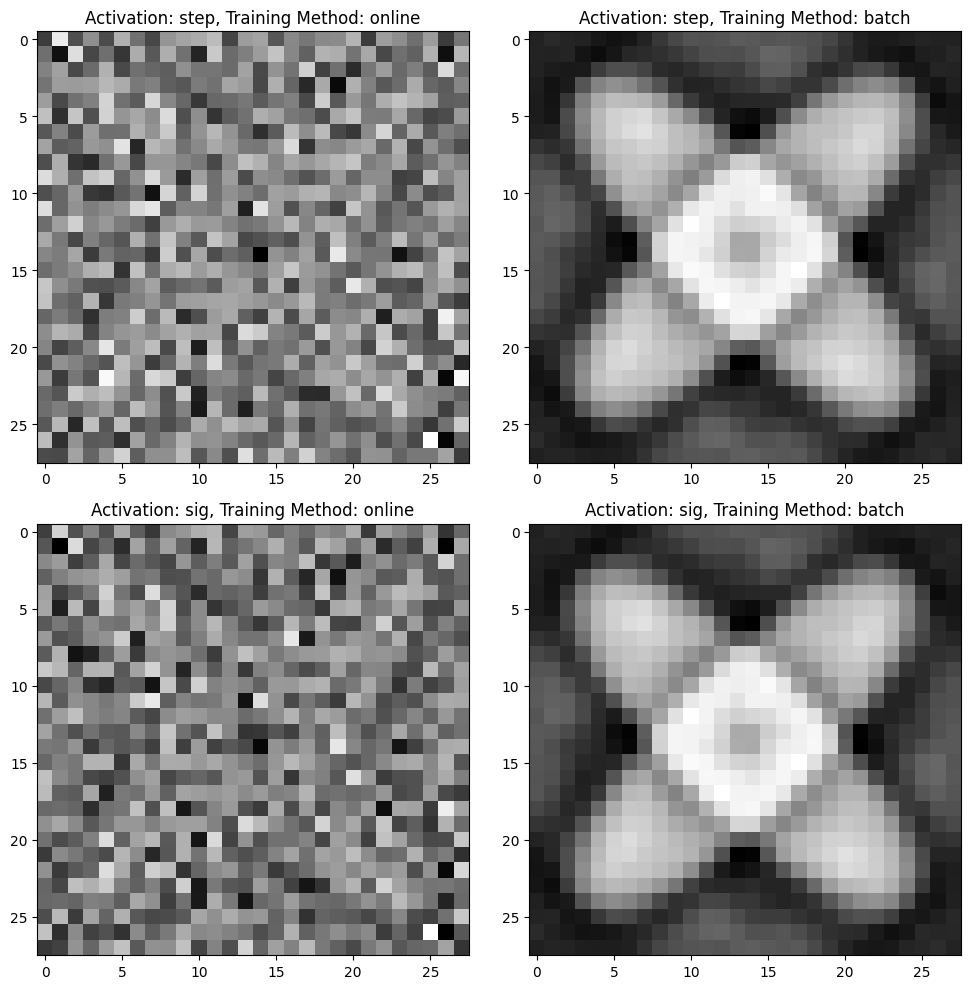

In [17]:
def graph_weight(weights):
    # Setup subplot for the graphs
    fig,axs = plt.subplots(2,2, figsize=(10, 10))
    # Loop through each combination of activation x training method
    for i, weights_dict in enumerate(weights):
        activation=weights_dict['Activation']
        method=weights_dict['Training Method']
        weight=weights_dict['Weights']
        # Reshape the weight back into a 28*28 grid
        weight=weight.reshape((28, 28))
        # Plot the weights
        ax= axs[i//2, i % 2]
        ax.imshow(weight, cmap='grey')
        ax.set_title(f'Activation: {activation}, Training Method: {method}')
    plt.tight_layout()
    plt.show()
graph_weight(weights_50)

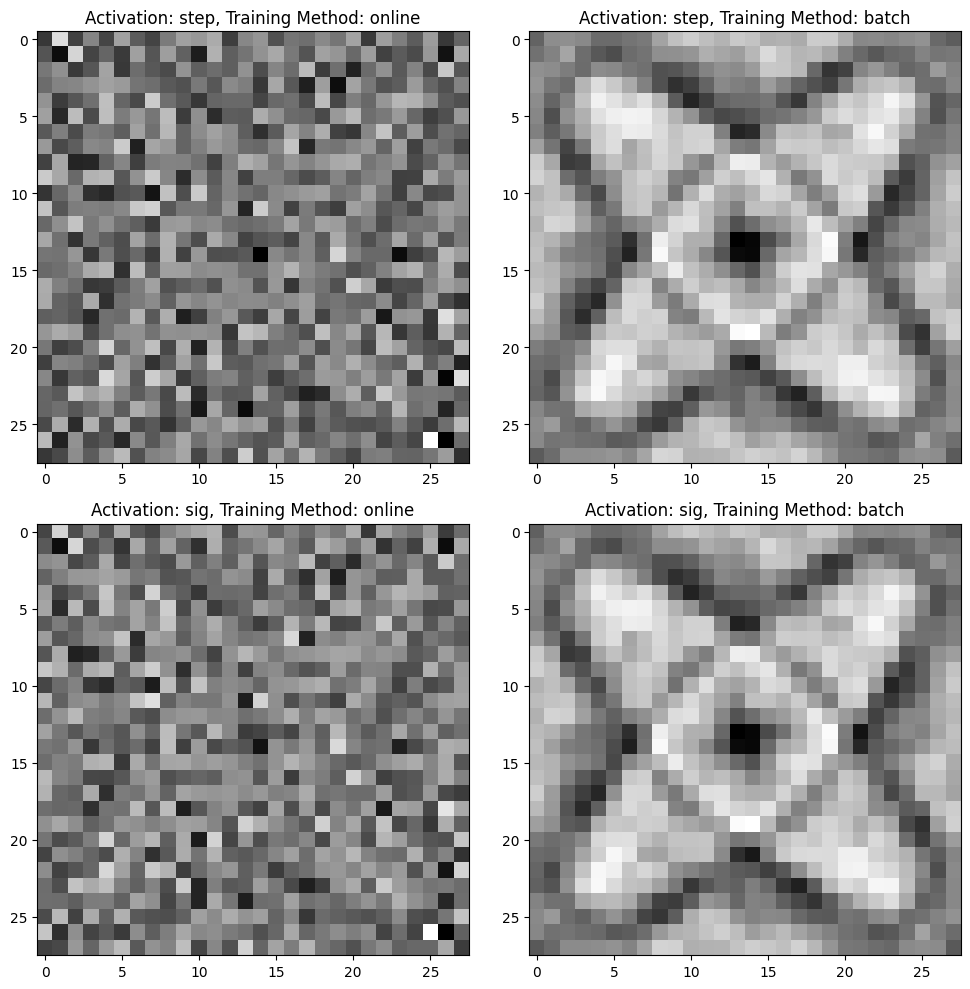

In [18]:
graph_weight(weights_1000)

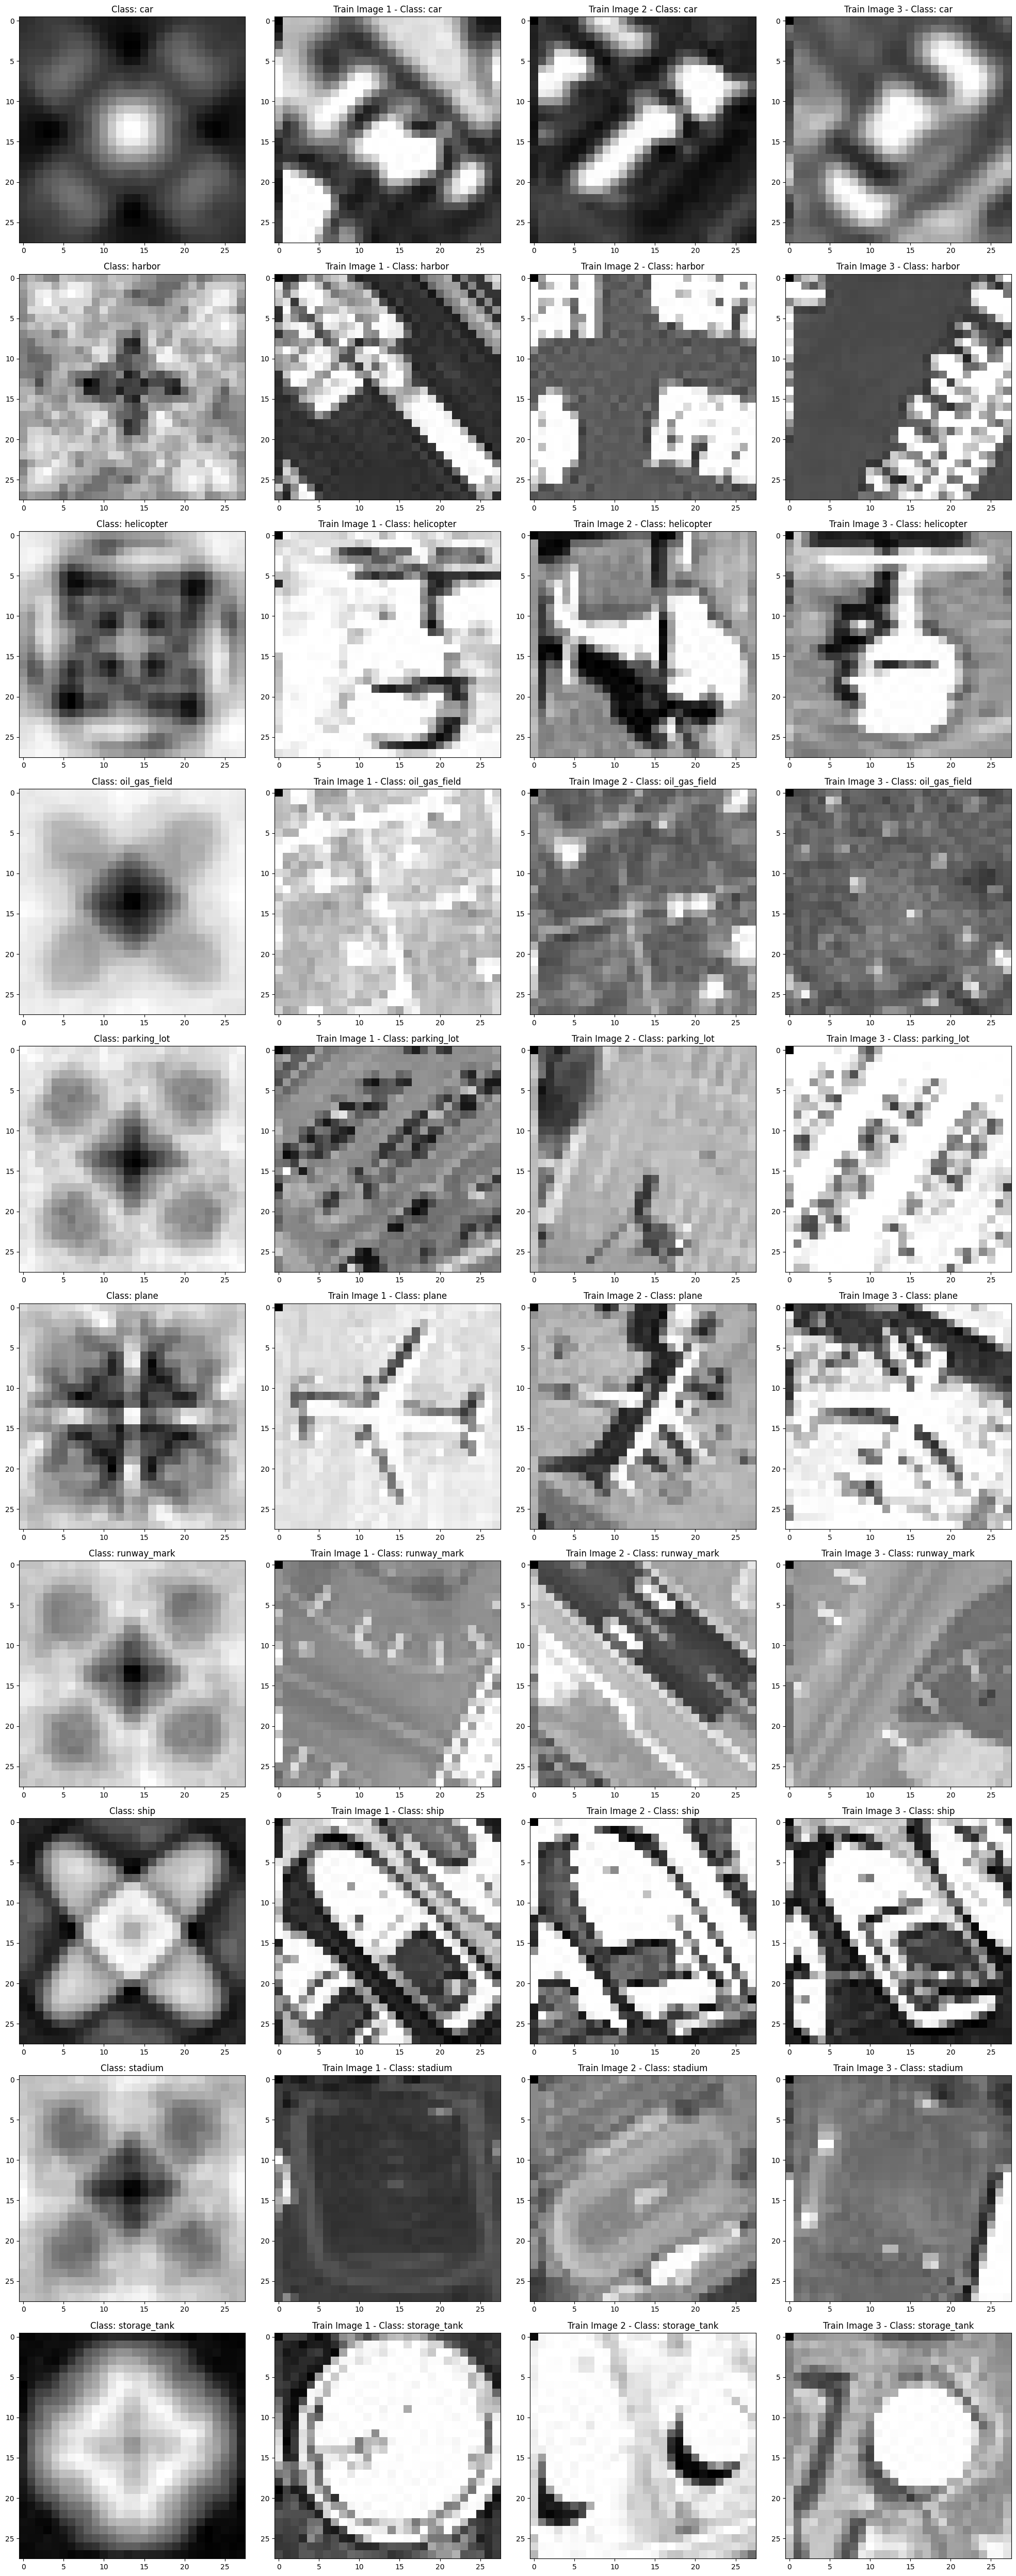

In [19]:
def visualize_weights_and_images(weights_table, train_df):
    num_models = len(weights_table['Weights'][0])
    num_classes = len(weights_table)
    fig, axes = plt.subplots(num_classes, 4, figsize=(20, 50))

    for class_idx in range(num_classes):
        # Find the actual name of the class
        class_name = classes.loc[class_idx,'class']
        
        # Plot weights
        weights = np.array(weights_table['Weights'][class_idx])
        ax = axes[class_idx, 0]
        ax.imshow(weights.reshape(28, 28), cmap='gray')
        ax.set_title(f'Class: {class_name}')

        # Plot images from train_df for the same class
        images = train_df[train_df['class'] == class_idx].head(3).values[:,:784]
        for i, image in enumerate(images):
            ax = axes[class_idx, i+1]
            ax.imshow(np.array(image).reshape(28, 28), cmap='gray')
            ax.set_title(f'Train Image {i+1} - Class: {class_name}')

    plt.tight_layout()
    plt.show()
visualize_weights_and_images(weight_sig_batch[['Class','Weights']], train_df)

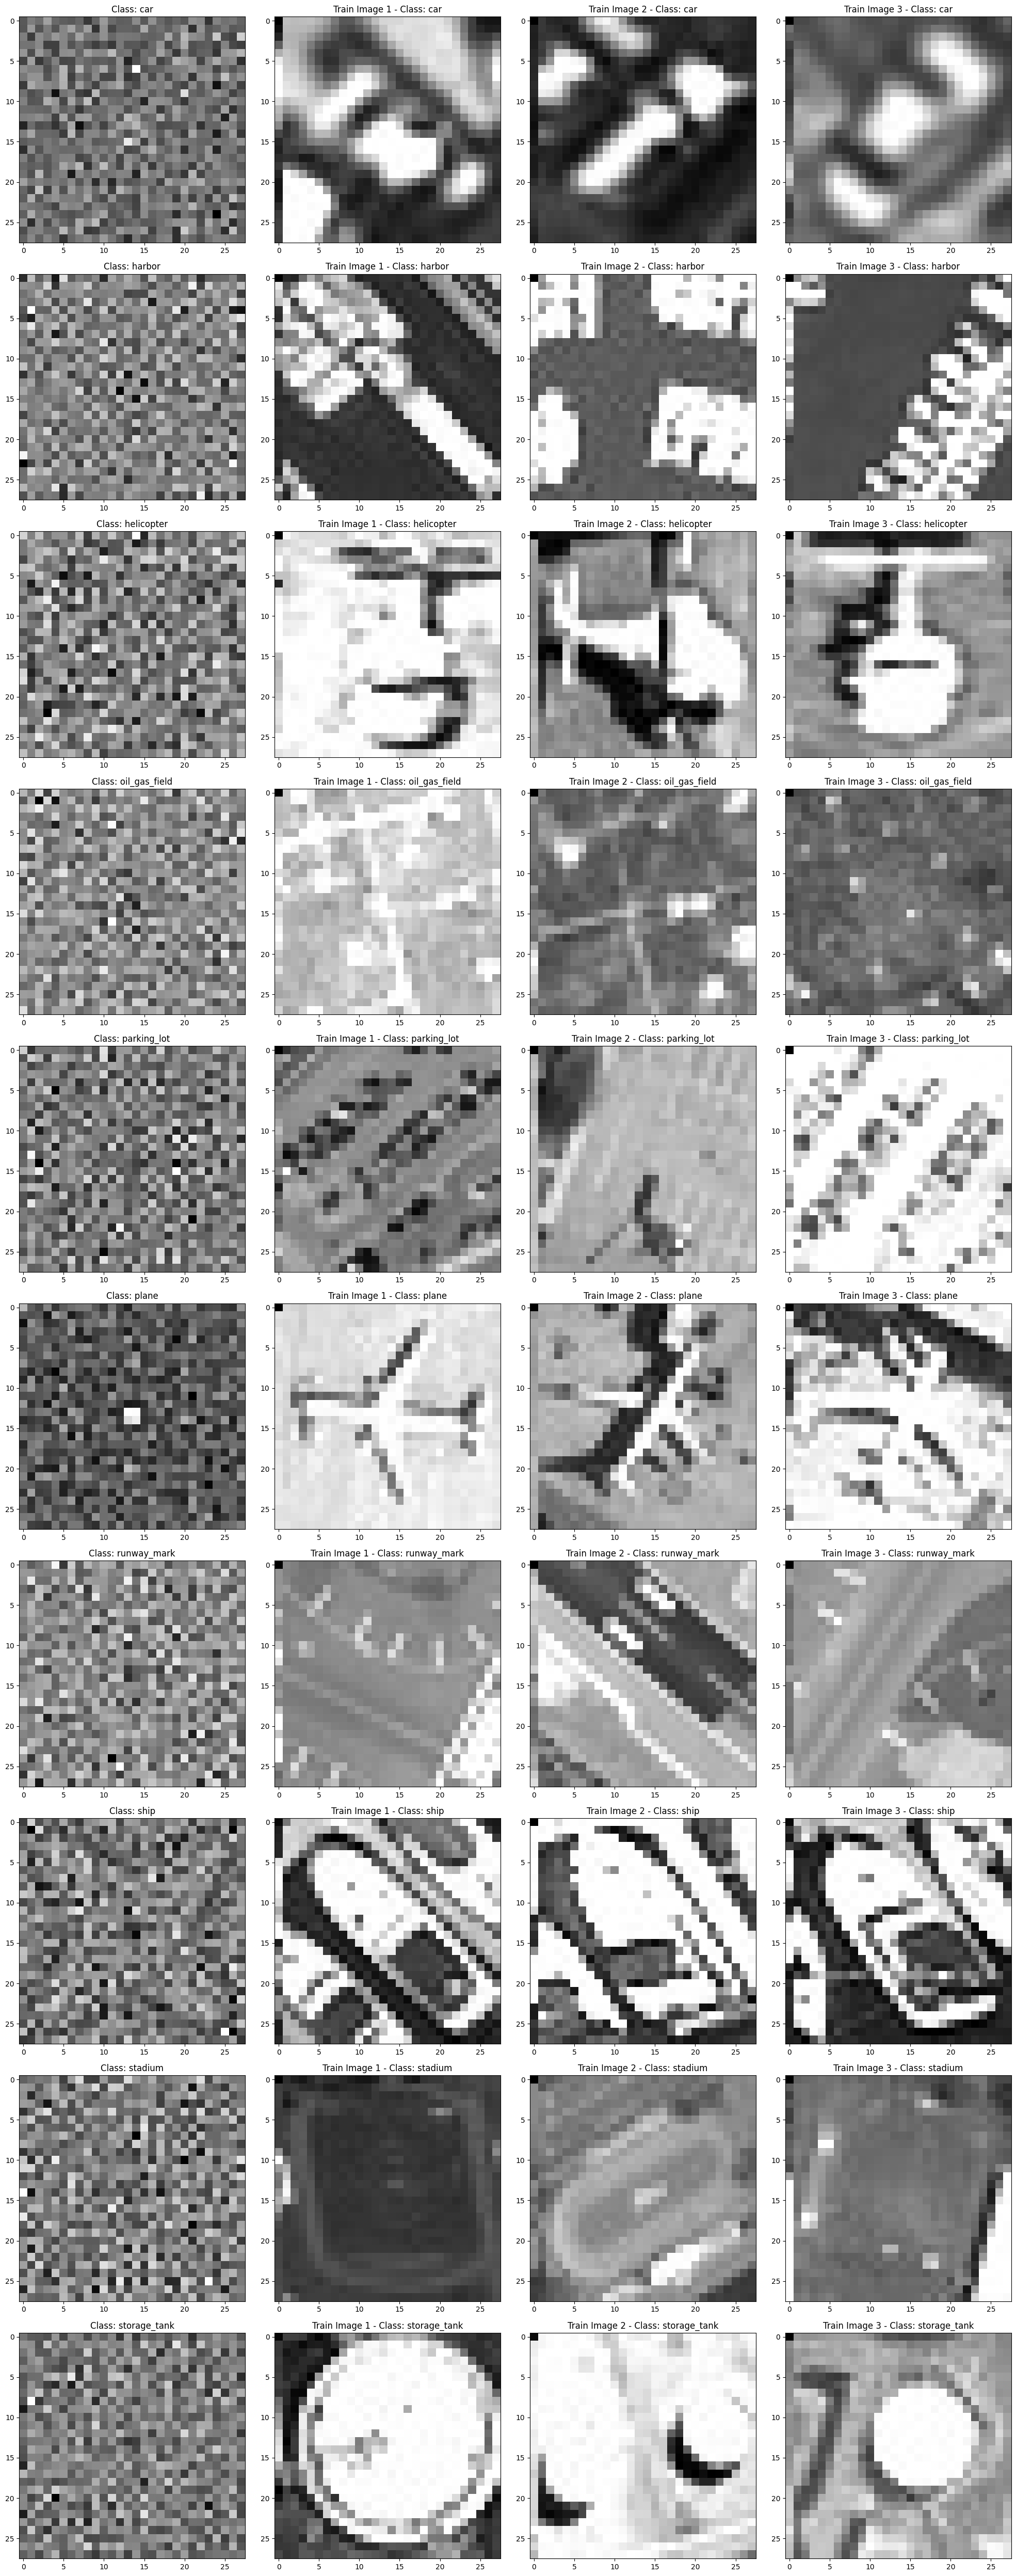

In [20]:
visualize_weights_and_images(weight_sig_online[['Class','Weights']], train_df)